In [1]:
from __future__ import division
%matplotlib inline
import cPickle
import datetime
from dateutil import parser
import itertools
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import numpy as np
import os
import pandas as pd
from scipy.integrate import quadrature, romberg
from scipy.interpolate import interp1d
from scipy.special import legendre
from tqdm import tqdm_notebook

# Load the sunphotometer data

In [16]:
def parseSunPhotoMeter(path, usecols):
    """Parse the sunphotometer data."""

    def dateparse(d, t):
        return pd.datetime.strptime(d+' '+t, '%d:%m:%Y %H:%M:%S')

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=usecols
    )

    wavelengths = [float(i.split("[")[0]) for i in df.columns]
    df = df.rename(index=str, columns=dict(itertools.izip(df.columns, wavelengths)))

    return df, wavelengths

In [17]:
pfn_path = r"../../data/phase_functions/170422_170422_Technion_Haifa_IL.pfn"
df_441, wavelengths = parseSunPhotoMeter(
    pfn_path,
    usecols=[0, 1]+list(range(3, 86))
)
df_674, wavelengths = parseSunPhotoMeter(
    pfn_path,
    usecols=[0, 1]+list(range(86, 169))
)
df_871, wavelengths = parseSunPhotoMeter(
    pfn_path,
    usecols=[0, 1]+list(range(169, 252))
)
df_1020, wavelengths = parseSunPhotoMeter(
    pfn_path,
    usecols=[0, 1]+list(range(252, 335))
)

# Show one of the phase functions

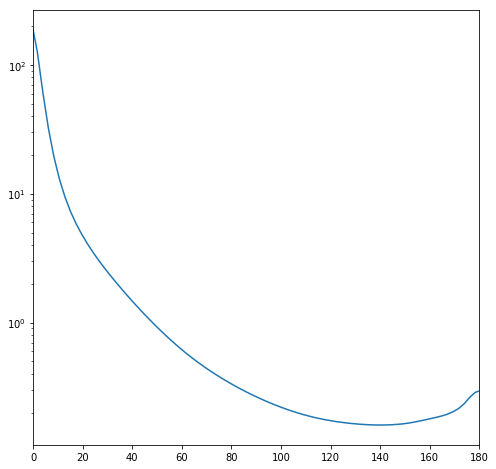

In [18]:
ax = df_674.iloc[3].transpose().plot(logy=True)

The (intensity) phase function is conventionally normalized as follows

$$\int_0^{2\pi} \int_0^\pi P(\Theta) \sin(\Theta) d\Theta d\phi = 4 \pi$$

Which is equivalent to

$$\int_{-1}^1 P(\cos{\Theta}) d(\cos{\Theta}) = 2$$

Integrating the phase function from the sunphotometer gives:

In [19]:
mu = np.cos(np.radians(wavelengths[::-1]))
phase = df_674.iloc[3].values[::-1]
np.trapz(phase, mu)

2.0405237504684393

# Calculate the Legendre Coefficients

## Use quadrature integration

In [20]:
COFFES_NUM = 300

In [22]:
coeffs_sph_nm = []
for l in tqdm_notebook(range(COFFES_NUM)):
    lg = legendre(l, monic=False)
    coeffs_sph_nm.append(quadrature(func, -1, 1, args=(lg,), maxiter=1000, )[0])

C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.473984e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.043273e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.591737e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.134632e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.682453e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 

### Show Coefficients

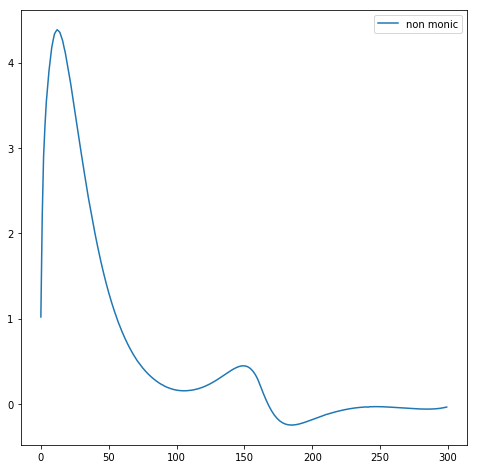

In [95]:
plt.plot(coeffs_sph_nm, label="non monic")
plt.legend()

In [26]:
mu_new = np.linspace(-1, 1, 300)
def calcPhase(coeffs, monic=False):
    phase_gauss = 0
    for l, coeff in enumerate(coeffs):
        phase_gauss += legendre(l, monic)(mu_new) * coeff
    return phase_gauss

## Test with other phase functions

### reff=0.03 , veff=0.5

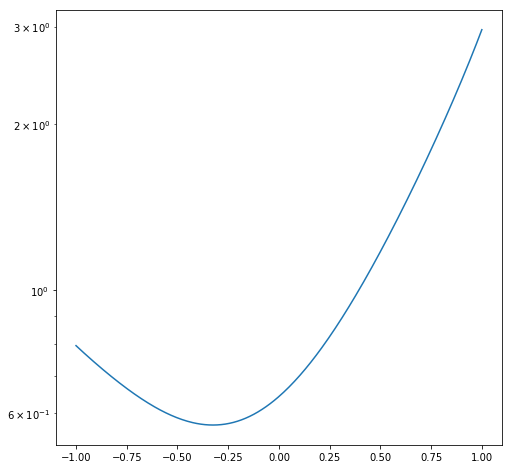

In [18]:
data = "1.00000    0.79736    0.77397    0.24840    0.08868    0.03229    0.01338    0.00546    0.00254    0.00110    0.00057    0.00025    0.00015    0.00006    0.00004    0.00002    0.00001    0.00001    0.00001"
coeffs_003 = np.array([float(i) for i in data.split()])
mu_new, phase_003 = calcPhase(coeffs_003)
plt.semilogy(mu_new, phase_003, label="0.03")

### reff=1.0 , veff=0.5

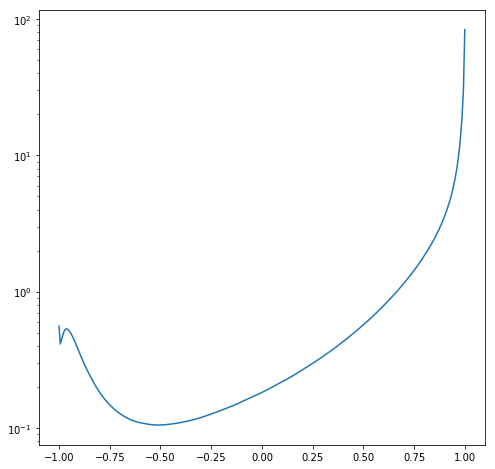

In [19]:
data = "1.00000    2.15911    3.02032    3.05411    3.35892    3.27002    3.34415    3.31194    3.23289    3.21150    3.04820    3.00166    2.81696    2.73206    2.56046    2.44448    2.29818    2.16477    2.04356    1.90610    1.80511    1.67338    1.58725    1.46738    1.39186    1.28615    1.21877    1.12735    1.06777    0.98850    0.93448    0.86577    0.81850    0.75880    0.71788    0.66461    0.62728    0.58296    0.55209    0.51380    0.48655    0.45428    0.43078    0.40049    0.37851    0.35267    0.33568    0.31203    0.29660    0.27618    0.26334    0.24455    0.23374    0.21774    0.20890    0.19397    0.18524    0.17276    0.16487    0.15420    0.14754    0.13836    0.13228    0.12389    0.11838    0.11064    0.10603    0.09941    0.09560    0.08928    0.08568    0.08048    0.07741    0.07247    0.06955    0.06552    0.06299    0.05919    0.05696    0.05352    0.05155    0.04839    0.04667    0.04385    0.04234    0.03981    0.03846    0.03619    0.03491    0.03294    0.03179    0.02999    0.02897    0.02734    0.02642    0.02497    0.02412    0.02276    0.02198    0.02082    0.02017    0.01909    0.01846    0.01745    0.01689    0.01597    0.01549    0.01467    0.01424    0.01347    0.01306    0.01238    0.01201    0.01137    0.01102    0.01047    0.01017    0.00966    0.00937    0.00891    0.00864    0.00821    0.00796    0.00758    0.00737    0.00700    0.00681    0.00646    0.00628    0.00598    0.00581    0.00554    0.00539    0.00514    0.00501    0.00477    0.00463    0.00442    0.00430    0.00410    0.00399    0.00381    0.00371    0.00354    0.00345    0.00330    0.00321    0.00307    0.00299    0.00286    0.00278    0.00266    0.00260    0.00248    0.00242    0.00231    0.00225    0.00215    0.00210    0.00201    0.00196    0.00187    0.00183    0.00175    0.00171    0.00164    0.00160    0.00153    0.00149    0.00143    0.00140    0.00134    0.00131    0.00126    0.00123    0.00118    0.00115    0.00110    0.00108    0.00103    0.00101    0.00097    0.00095    0.00091    0.00089    0.00086    0.00084    0.00080    0.00079    0.00075    0.00074    0.00071    0.00069    0.00067    0.00065    0.00063    0.00061    0.00059    0.00058    0.00056    0.00055    0.00052    0.00051    0.00049    0.00048    0.00047    0.00046    0.00044    0.00043    0.00041    0.00040    0.00039    0.00038    0.00037    0.00036    0.00035    0.00034    0.00033    0.00032    0.00031    0.00030    0.00029    0.00029    0.00028    0.00027    0.00026    0.00026    0.00025    0.00024    0.00023    0.00023    0.00022    0.00022    0.00021    0.00020    0.00020    0.00019    0.00019    0.00018    0.00018    0.00017    0.00017    0.00016    0.00016    0.00016    0.00015    0.00015    0.00014    0.00014    0.00014    0.00013    0.00013    0.00013    0.00012    0.00012    0.00012    0.00011    0.00011    0.00011    0.00010    0.00010    0.00010    0.00010    0.00009    0.00009    0.00009    0.00009    0.00009    0.00008    0.00008    0.00008    0.00008    0.00008    0.00007    0.00007    0.00007    0.00007    0.00007    0.00006    0.00006    0.00006    0.00006    0.00006    0.00006    0.00006    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001"
coeffs_1 = np.array([float(i) for i in data.split()])
mu_new, phase_1 = calcPhase(coeffs_1)
plt.semilogy(mu_new, phase_1, label="1.0")

### All together now

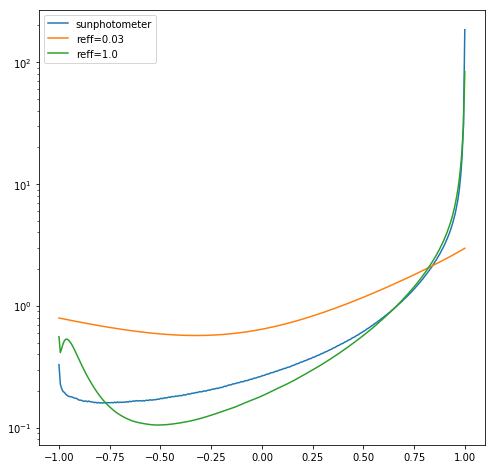

In [22]:
plt.semilogy(mu_new, phase_sph, label="sunphotometer")
plt.semilogy(mu_new, phase_003, label="reff=0.03")
plt.semilogy(mu_new, phase_1, label="reff=1.0")
plt.legend()

## Convert some of Frank's functions to Python

### LEGENDRE_ALL - calculate legendre polynomial at some scatter angle

      SUBROUTINE LEGENDRE_ALL (COSSCAT, NLEG, P)
C       This subroutine computes a set of Legendre polynomials for
C     a particular scattering angle COSSCAT.  NLEG is the maximum term.
C     The Legendre functions evaluated at COSSCAT are returned in 
C     P, starting at l=0 and ending with l=NLEG  (NLEG+1 terms).
      INTEGER NLEG
      DOUBLE PRECISION COSSCAT, P(0:NLEG)
      INTEGER L
      DOUBLE PRECISION X, PL, PL1, PL2

      X = DBLE(COSSCAT)
      IF (X*X .GT. 1.) STOP 'LEGENDRE_ALL: |COSSCAT| larger than 1'
C         Use the stable upward recursion on l, starting from P_0
      PL2 = 1.0D0
      P(0) = PL2
      IF (NLEG .GT. 1) THEN
        PL1 = X
        P(1) = X
      ENDIF
      DO L = 2, NLEG
        PL = ( (2*L-1)*X*PL1 - (L-1)*PL2 )/L
        P(L) = PL
        PL2 = PL1
        PL1 = PL
      ENDDO
      RETURN
      END


In [91]:
def LEGENDRE_ALL(COSSCAT, NLEG):
    """This subroutine computes a set of Legendre polynomials for
    a particular scattering angle COSSCAT.  NLEG is the maximum term.
    The Legendre functions evaluated at COSSCAT are returned in 
    P, starting at l=0 and ending with l=NLEG  (NLEG+1 terms).
    """
    
    P = np.zeros(NLEG+1, dtype=np.float)

    X = COSSCAT# * COSSCAT
    assert X <= 1, "COSSCAT larger than 1."

    PL2 = 1.0
    P[0] = PL2
    if NLEG > 1:
        PL1 = X
        P[1] = X
    for L in range(2, NLEG+1):
        PL = ( (2*L-1)*X*PL1 - (L-1)*PL2 )/L
        P[L] = PL
        PL2 = PL1
        PL1 = PL

    return P

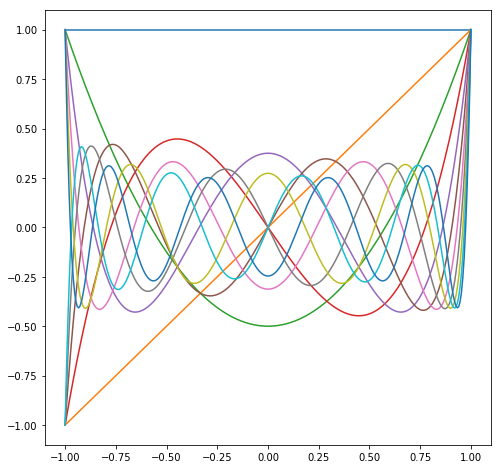

In [97]:
degree = 10
leg = [LEGENDRE_ALL(i, degree) for i in mu_new]
plt.plot(mu_new, np.array(leg))

## Franks' phase function visualization (plotscattab.f90)

In [84]:
NANGLE = 300
ANGLE = np.linspace(0, math.degrees(np.pi), NANGLE)
PHASE = np.zeros(NANGLE, dtype=np.float)
for J in range(NANGLE):
    MU = np.cos(math.radians(ANGLE[J]))
    SCAT = 0.0
    PL1 = 1.0
    PL = 1.0
    for L in range(len(coeffs_sph_nm)):
        if L > 0:
            PL = (2*L - 1) * MU * PL1 / L - (L - 1) * PL2 / L
        SCAT = SCAT + coeffs_sph_nm[L] * PL
        PL2 = PL1
        PL1 = PL
            
    PHASE[J] = SCAT

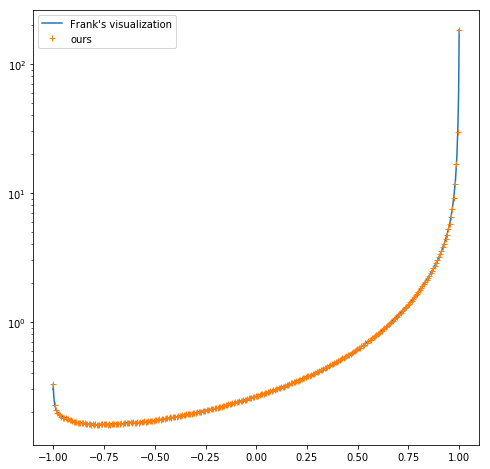

In [96]:
plt.semilogy(np.cos(np.radians(ANGLE)), PHASE, label="Frank's visualization")
plt.semilogy(mu_new, calcPhase(coeffs_sph_nm, monic=False), "+", label="ours")
plt.legend()